# Demo

Contents:

1. Layer-wise Relevance Propagation (LRP)
1. Quantitative evaluation of LRP explanation using Region Perturbation (perturbation modes: inpainting, random)

## LRP

Files already downloaded and verified
Finished 'relevance' in 1.6019 secs


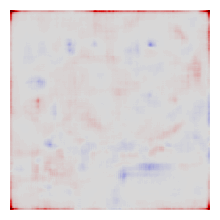

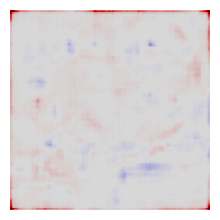

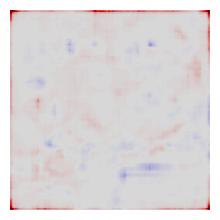

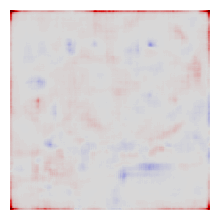

In [2]:
from typing import Callable, Dict, List, Tuple, Union

import numpy
import torch
import torchvision
from matplotlib import pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import lrp.plot
from lrp import image, rules
from lrp.core import LRP
from lrp.filter import LayerFilter
from lrp.rules import LrpEpsilonRule, LrpGammaRule, LrpZBoxRule, LrpZeroRule
from lrp.zennit.types import AvgPool, Linear

# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for VGG16
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)



# Input data
# Image is in RGB mode with range [0,1]
# img_bgr_hwc_float_0_1: numpy.array = image.load_img_norm_zero_one('data/castle.jpg')
# X = lrp.norm.ImageNetNorm.transform(img_bgr_hwc_float_0_1)

# Simulate batch by adding a new dimension so that X is in NCHW format
# N is the batch size
# C is the number of channels
# H is the height
# W is the width
# X = torch.unsqueeze(X, 0)

# Hide plot axes
# plt.axis('off')

# Plot input image
# lrp.plot.plot_imagenet(X)

# Model
# Modify VGG16 for CIFAR-10
model = torchvision.models.vgg16(pretrained=True)
model.classifier[6] = torch.nn.Linear(4096, 10)  # Adjust the classifier for 10 CIFAR-10 classes
model.eval()

# Global dictionary to store activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks as before
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
        layer.register_forward_hook(get_activation(name))
        
def get_class_loader(dataset, class_index, batch_size=4):
    # Filter dataset for a specific class
    class_data = [data for data in dataset if data[1] == class_index]
    
    # Create a DataLoader for the class-specific dataset
    class_loader = torch.utils.data.DataLoader(class_data, batch_size=batch_size, shuffle=True)
    return class_loader

# Choose a class index (e.g., 3 for 'Cat' in CIFAR-10)
class_index = 3

# Get DataLoader for the specific class
class_loader = get_class_loader(trainset, class_index)

# Clear previous activations
activations.clear()

# Process a batch of images from the specific class
class_images, class_labels = next(iter(class_loader))
output = model(class_images)

# At this point, 'activations' will contain the activations for the specific class



# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.zeros(*shape))
high: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.ones(*shape))

# Init layer filter
target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type: LayerFilter = LayerFilter(model=model,
                                                      target_types=target_types)

name_map: List[Tuple[List[str], rules.LrpRule,
                     Dict[str, Union[torch.Tensor, float]]]]

# LRP Composite from Montavon's lrp-tutorial
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

# Init LRP
lrp_instance: LRP = LRP(model)

# Prepare model layers for LRP
lrp_instance.convert_layers(name_map)

# Compute relevance attributions
# R: torch.Tensor = lrp_instance.relevance(X)

# Get a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Forward pass to trigger hooks and get output (for printing activation values)
output = model(images)

# Compute relevance attributions for CIFAR-10 images
R = lrp_instance.relevance(images)


# Display heatmap
lrp_instance.heatmap(R, width=2, height=2)

In [3]:
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
        print(f"Registering hook for layer: {name}")
        layer.register_forward_hook(get_activation(name))


Registering hook for layer: features.0
Registering hook for layer: features.2
Registering hook for layer: features.5
Registering hook for layer: features.7
Registering hook for layer: features.10
Registering hook for layer: features.12
Registering hook for layer: features.14
Registering hook for layer: features.17
Registering hook for layer: features.19
Registering hook for layer: features.21
Registering hook for layer: features.24
Registering hook for layer: features.26
Registering hook for layer: features.28
Registering hook for layer: classifier.0
Registering hook for layer: classifier.3
Registering hook for layer: classifier.6


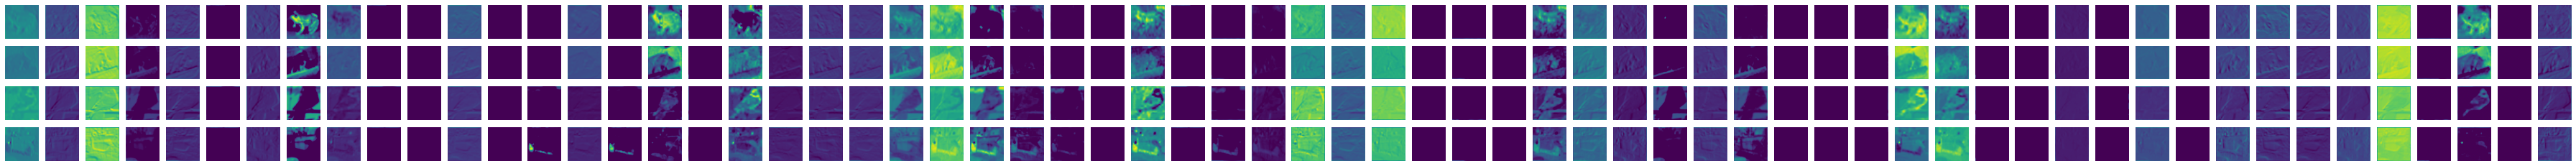

In [4]:
import matplotlib.pyplot as plt

def plot_activations_for_layer(layer_activations):
    # Assuming layer_activations shape is [batch_size, num_filters, height, width]
    batch_size, num_filters, _, _ = layer_activations.shape
    
    fig, axes = plt.subplots(batch_size, num_filters, figsize=(num_filters, batch_size))
    
    for i in range(batch_size):
        for j in range(num_filters):
            ax = axes[i, j]
            ax.imshow(layer_activations[i, j].cpu().numpy(), cmap='viridis')
            ax.axis('off')
    
    plt.show()

# Example: Plot activations for the first conv layer
# Replace 'first_conv_layer_name' with the actual name of the first conv layer in your model
plot_activations_for_layer(activations['features.0'])


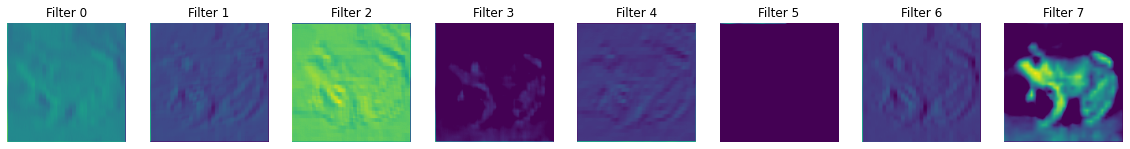

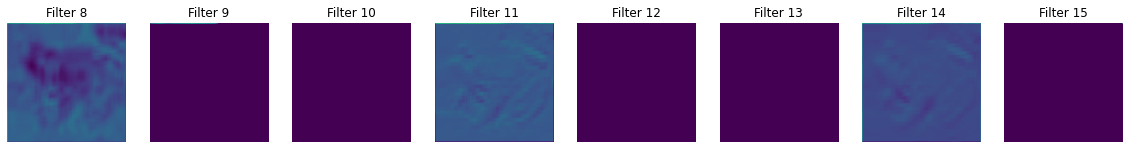

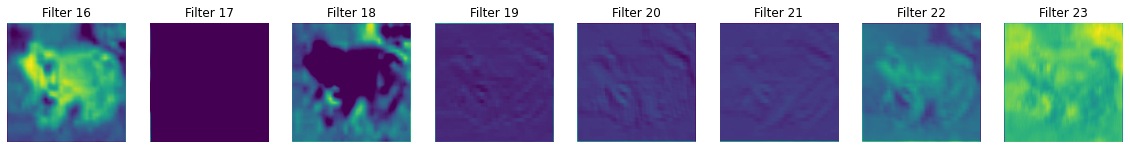

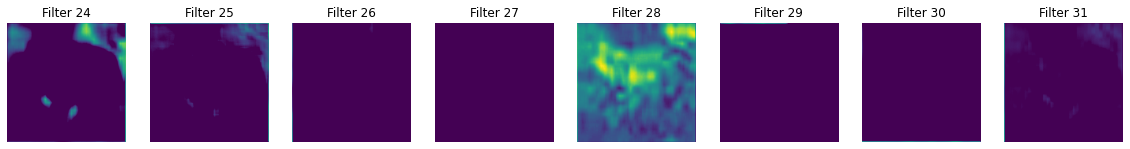

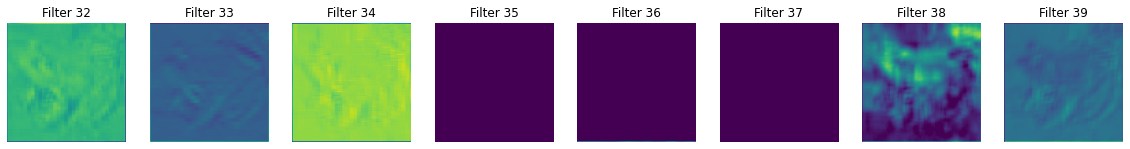

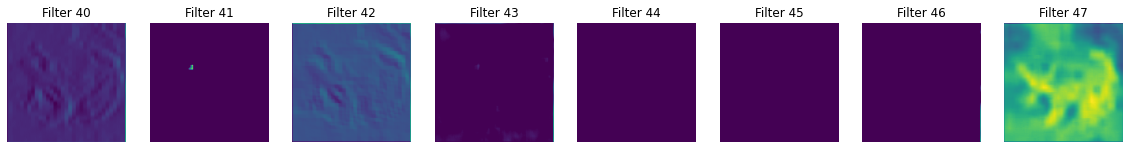

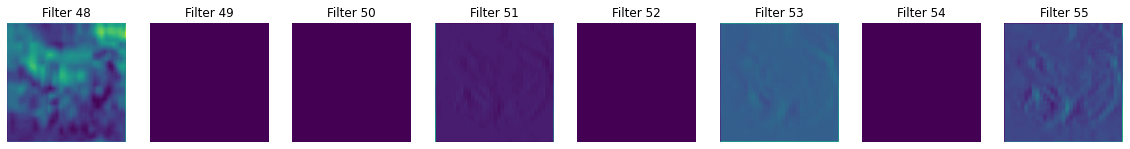

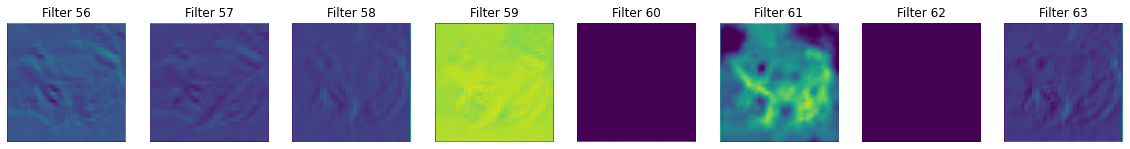

In [5]:
import matplotlib.pyplot as plt

def plot_activations_for_subset_of_filters(layer_activations, num_images=1, filters_per_fig=16):
    # Assuming layer_activations shape is [batch_size, num_filters, height, width]
    _, num_filters, _, _ = layer_activations.shape
    
    # Limit the number of images
    num_images = min(layer_activations.shape[0], num_images)
    
    # Iterate over filters in sets
    for start_filter in range(0, num_filters, filters_per_fig):
        end_filter = min(start_filter + filters_per_fig, num_filters)
        fig, axes = plt.subplots(num_images, end_filter - start_filter, figsize=(20, 10))

        for i in range(num_images):
            for j, filter_idx in enumerate(range(start_filter, end_filter)):
                ax = axes[i, j] if num_images > 1 else axes[j]
                ax.imshow(layer_activations[i, filter_idx].cpu().numpy(), cmap='viridis')
                ax.axis('off')
                ax.set_title(f'Filter {filter_idx}')

        plt.show()

# Example: Plot activations for the first conv layer for 5 images
plot_activations_for_subset_of_filters(activations['features.0'], num_images=1, filters_per_fig=8)


In [6]:
# Example: Collect activations for two classes
class_indices = [3, 5]  # Example class indices

class_activations = {}
for class_index in class_indices:
    class_loader = get_class_loader(trainset, class_index)
    class_images, _ = next(iter(class_loader))
    output = model(class_images)

    class_activations[class_index] = dict(activations)

# Now class_activations contains activations for each class in one batch
# You can compare these, e.g., by computing and comparing statistics


In [7]:
# Function to compute mean and standard deviation of activations
def compute_activation_statistics(activation_dict):
    stats = {}
    for layer, activation in activation_dict.items():
        stats[layer] = {
            'mean': activation.mean().item(),
            'std': activation.std().item(),
            'median': activation.median().item(),
            'min': activation.min().item(),
            'max': activation.max().item(),
            'range': activation.max().item() - activation.min().item()
        }
    return stats

# Dictionary to store statistics for each class
class_stats = {}

# Compute statistics for each class
for class_index, activations in class_activations.items():
    class_stats[class_index] = compute_activation_statistics(activations)

# Now you can compare the mean and standard deviation of activations between the two classes
for layer in class_stats[class_indices[0]].keys():
    print(f"Layer: {layer}")
    for class_index in class_indices:
        print(f"Class {class_index} - Mean: {class_stats[class_index][layer]['mean']}, Std Dev: {class_stats[class_index][layer]['std']}")
    print()


Layer: features.0
Class 3 - Mean: 0.18750986456871033, Std Dev: 0.21483463048934937
Class 5 - Mean: 0.1874839961528778, Std Dev: 0.2111479640007019

Layer: features.2
Class 3 - Mean: 0.17508284747600555, Std Dev: 0.3416092097759247
Class 5 - Mean: 0.1712522655725479, Std Dev: 0.3456903100013733

Layer: features.5
Class 3 - Mean: 0.3369874656200409, Std Dev: 0.40757378935813904
Class 5 - Mean: 0.32613083720207214, Std Dev: 0.385857492685318

Layer: features.7
Class 3 - Mean: 0.2199724316596985, Std Dev: 0.6014679074287415
Class 5 - Mean: 0.20300814509391785, Std Dev: 0.555453360080719

Layer: features.10
Class 3 - Mean: 0.4936498999595642, Std Dev: 0.8532586097717285
Class 5 - Mean: 0.460571825504303, Std Dev: 0.7825188040733337

Layer: features.12
Class 3 - Mean: 0.5189117789268494, Std Dev: 1.0981731414794922
Class 5 - Mean: 0.48660993576049805, Std Dev: 1.02027428150177

Layer: features.14
Class 3 - Mean: 0.24669095873832703, Std Dev: 0.9484384059906006
Class 5 - Mean: 0.227256268262

In [ ]:
# Example: Collect activations for entire dataset for two classes
class_indices = [3, 5]  # Example class indices

class_activations = {class_index: [] for class_index in class_indices}

for class_index in class_indices:
    class_loader = get_class_loader(trainset, class_index)
    
    for images, _ in class_loader:
        output = model(images)
        class_activations[class_index].append(dict(activations))




### LRP-modified Model

We will print the LRP-modified model to console. You will see that some layers were replaced with LRP layers.

In [8]:
lrp_instance.model

VGG(
  (features): Sequential(
    (0): LrpZBoxRule(
      (layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (low_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (high_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ReLU(inplace=True)
    (2): LrpGammaRule(
      (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): LrpGammaRule(
      (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (6): ReLU(inplace=True)
    (7): LrpGammaRule(
      (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv

In [9]:
for layers, rule, params in name_map:
    for layer in layers:
        print(f'{layer} {rule.__name__}')

features.0 LrpZBoxRule
features.2 LrpGammaRule
features.5 LrpGammaRule
features.7 LrpGammaRule
features.10 LrpGammaRule
features.12 LrpGammaRule
features.14 LrpGammaRule
features.17 LrpEpsilonRule
features.19 LrpEpsilonRule
features.21 LrpEpsilonRule
features.24 LrpEpsilonRule
features.26 LrpEpsilonRule
features.28 LrpEpsilonRule
avgpool LrpZeroRule
classifier.0 LrpZeroRule
classifier.3 LrpZeroRule
classifier.6 LrpZeroRule


## Region Perturbation

### Perturbation Mode: Inpainting

Finished '_flip' in 0.2946 secs
Finished '_flip' in 0.2756 secs
Finished '_flip' in 0.2717 secs
Finished '_flip' in 0.2665 secs
Finished '_flip' in 0.2745 secs
Finished '_flip' in 0.2792 secs
Finished '_flip' in 0.2687 secs
Finished '_flip' in 0.2740 secs
Finished '_flip' in 0.2826 secs
Finished '_flip' in 0.2844 secs
Finished '_flip' in 0.2761 secs
Finished '_flip' in 0.2869 secs
Finished '_flip' in 0.2958 secs
Finished '_flip' in 0.3029 secs
Finished '_flip' in 0.3002 secs
Finished '_flip' in 0.3107 secs
Finished '_flip' in 0.3101 secs
Finished '_flip' in 0.3336 secs
Finished '_flip' in 0.3323 secs
Finished '_flip' in 0.3380 secs
Finished '_flip' in 0.3477 secs
Finished '_flip' in 0.3487 secs
Finished '_flip' in 0.3438 secs
Finished '_flip' in 0.3438 secs
Finished '_flip' in 0.3616 secs
Finished '_flip' in 0.3610 secs
Finished '_flip' in 0.3660 secs
Finished '_flip' in 0.2901 secs
Finished '_flip' in 0.2560 secs
Finished '__call__' in 9.1745 secs
Finished 'calculate_auc_score' in 0.0

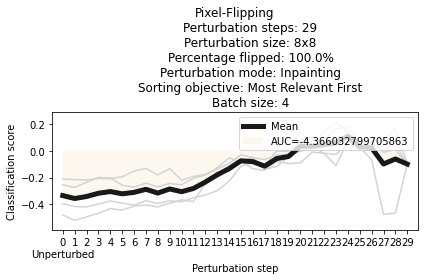

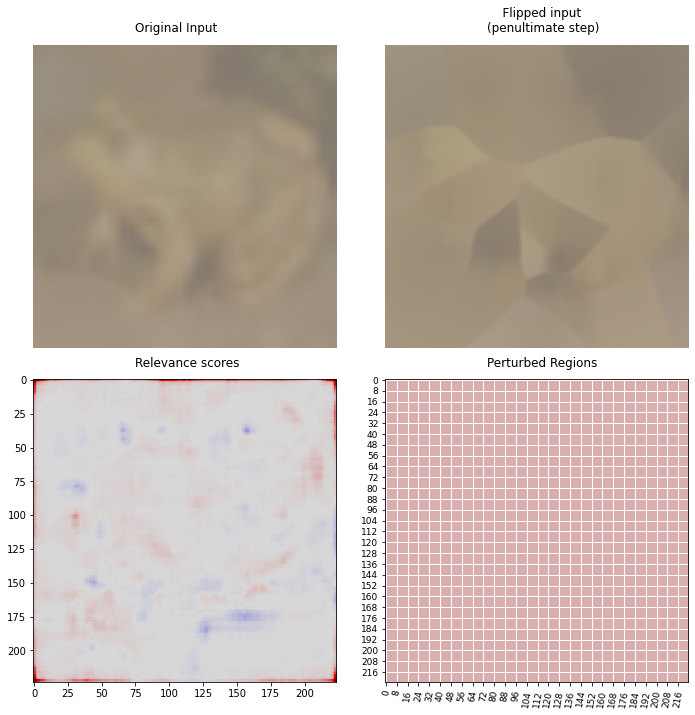

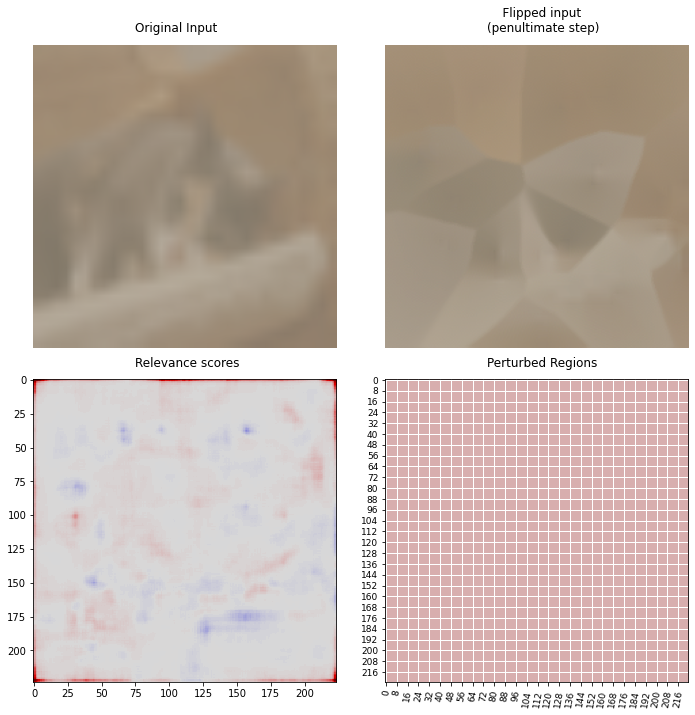

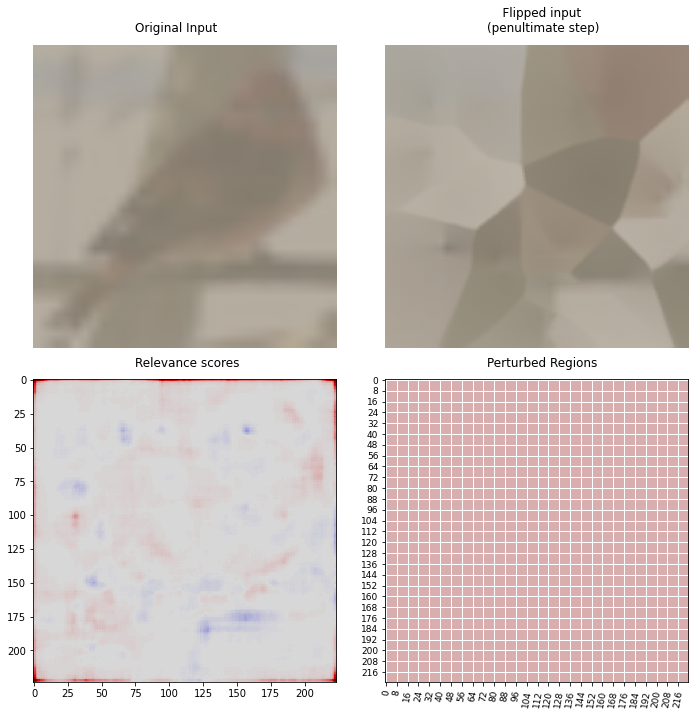

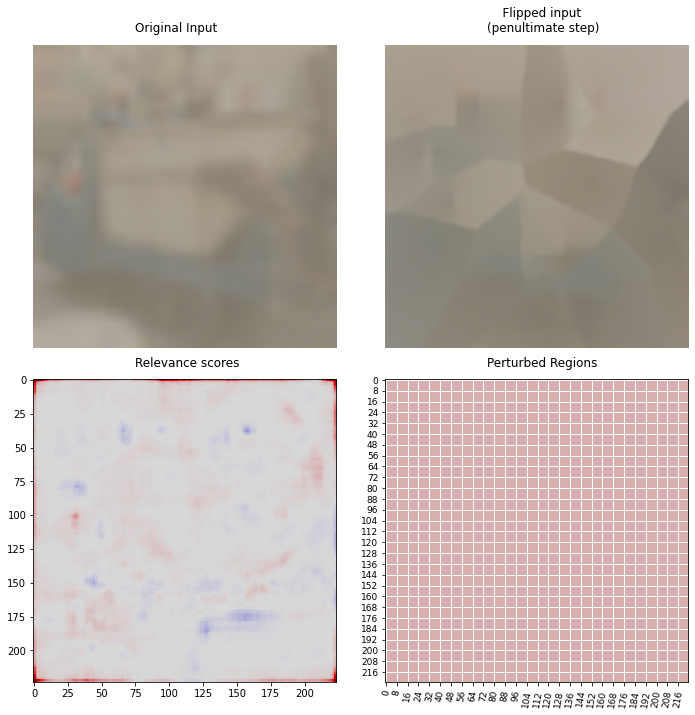

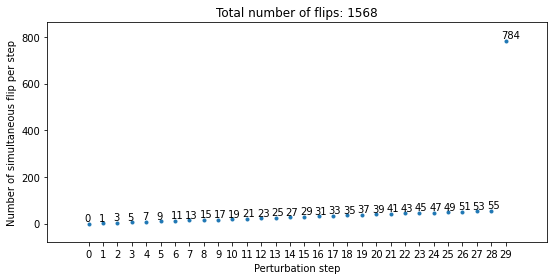

In [10]:
from pf.core import PixelFlipping
from pf.perturbation_modes.constants import PerturbModes
from typing import Callable

# Set parameters for the Pixel-Flipping algorithm
perturbation_steps: int = 29
perturbation_size: int = 8
perturb_mode: str = PerturbModes.INPAINTING  # or PerturbModes.RANDOM

# Create an instance of PixelFlipping
pixel_flipping_instance: PixelFlipping = PixelFlipping(
    perturbation_steps=perturbation_steps,
    perturbation_size=perturbation_size,
    perturb_mode=perturb_mode
)

# Clone the input and relevance scores
input_nchw: torch.Tensor = images.clone().detach()
relevance_scores_nchw: torch.Tensor = R.clone().detach()

# Function to return the classification score for the given input
# Adjust the index for CIFAR-10 classes (0 to 9)

# Example for class 'Cat' with index 3
class_index = 3  # Adjust this index based on the class you want to analyze


def forward_pass(input_nchw): 
    return model(input_nchw)[:, class_index] 


# Run the Pixel-Flipping algorithm
pixel_flipping_instance(input_nchw, relevance_scores_nchw, forward_pass)

# Plot the results
pixel_flipping_instance.plot_class_prediction_scores()
pixel_flipping_instance.plot_image_comparison()
pixel_flipping_instance.plot_number_of_flips_per_step()

## Region Perturbation

### Perturbation Mode: Random

Finished '_flip' in 0.2638 secs
Finished '_flip' in 0.2603 secs
Finished '_flip' in 0.2651 secs
Finished '_flip' in 0.2690 secs
Finished '_flip' in 0.2710 secs
Finished '_flip' in 0.2629 secs
Finished '_flip' in 0.2755 secs
Finished '_flip' in 0.2765 secs
Finished '_flip' in 0.2703 secs
Finished '_flip' in 0.2724 secs
Finished '_flip' in 0.2754 secs
Finished '_flip' in 0.2763 secs
Finished '_flip' in 0.2822 secs
Finished '_flip' in 0.2681 secs
Finished '_flip' in 0.2781 secs
Finished '_flip' in 0.2780 secs
Finished '_flip' in 0.2821 secs
Finished '_flip' in 0.2766 secs
Finished '_flip' in 0.2876 secs
Finished '_flip' in 0.2895 secs
Finished '_flip' in 0.2850 secs
Finished '_flip' in 0.2834 secs
Finished '_flip' in 0.2850 secs
Finished '_flip' in 0.2870 secs
Finished '_flip' in 0.2833 secs
Finished '_flip' in 0.2929 secs
Finished '_flip' in 0.2986 secs
Finished '_flip' in 0.2859 secs
Finished '_flip' in 0.2498 secs
Finished '__call__' in 8.2628 secs
Finished 'calculate_auc_score' in 0.0

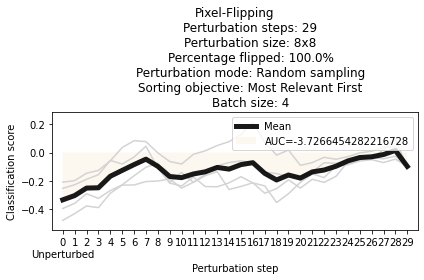

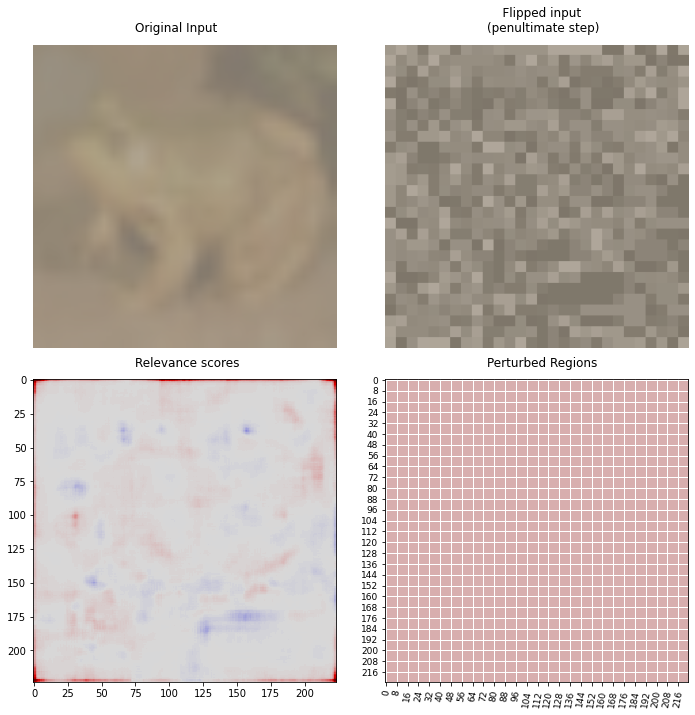

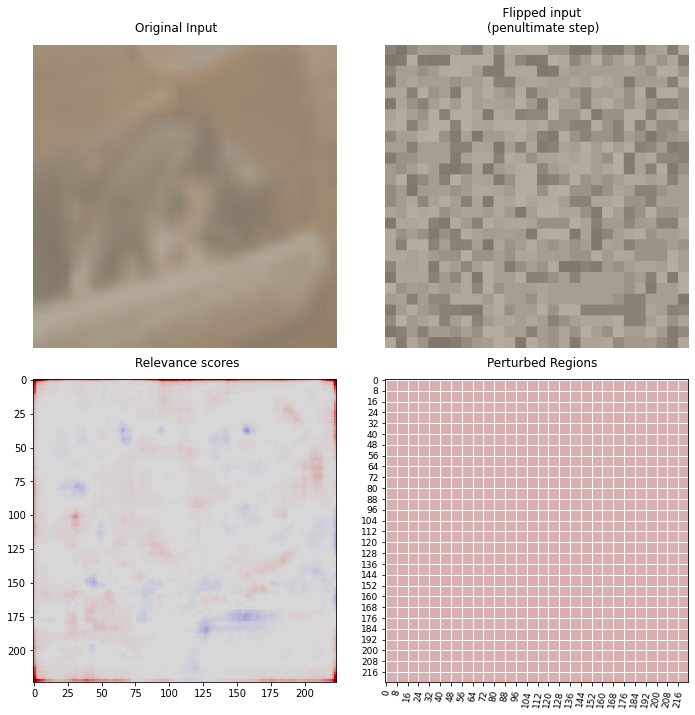

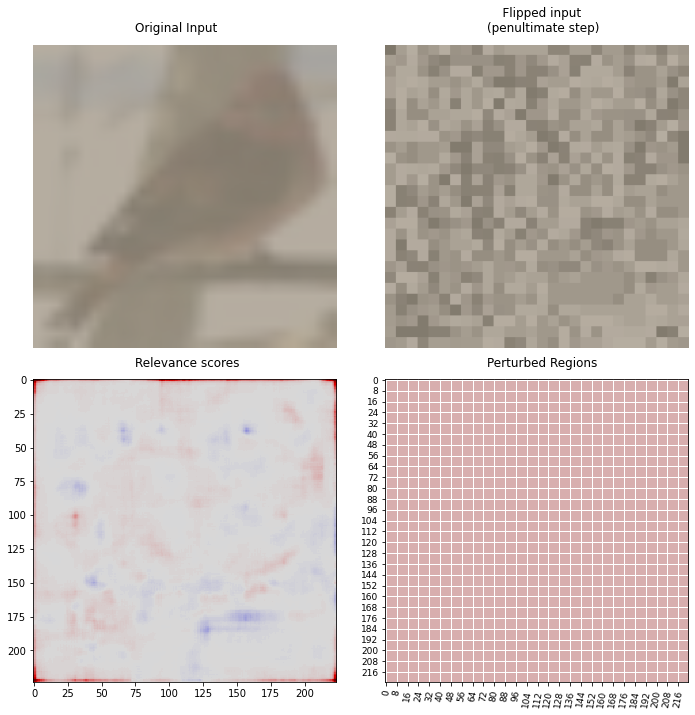

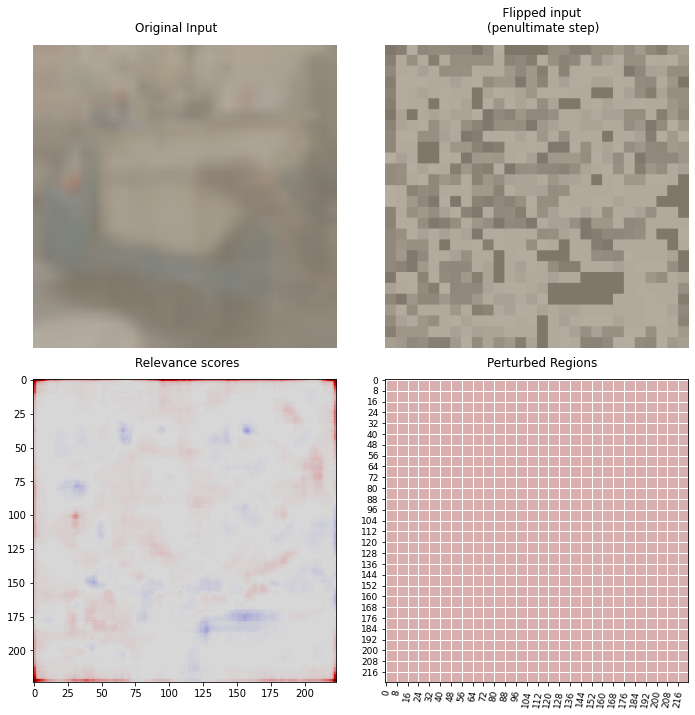

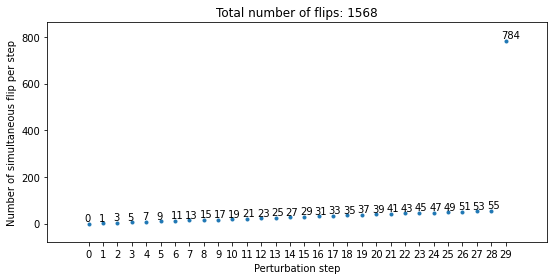

In [11]:
from pf.core import PixelFlipping
from pf.perturbation_modes.constants import PerturbModes
from typing import Callable

# Set parameters for the Pixel-Flipping algorithm
perturbation_steps: int = 29
perturbation_size: int = 8
perturb_mode: str = PerturbModes.RANDOM  # or PerturbModes.RANDOM

# Create an instance of PixelFlipping
pixel_flipping_instance: PixelFlipping = PixelFlipping(
    perturbation_steps=perturbation_steps,
    perturbation_size=perturbation_size,
    perturb_mode=perturb_mode
)

# Clone the input and relevance scores
input_nchw: torch.Tensor = images.clone().detach()
relevance_scores_nchw: torch.Tensor = R.clone().detach()

# Function to return the classification score for the given input
# Adjust the index for CIFAR-10 classes (0 to 9)

# Example for class 'Cat' with index 3
class_index = 3  # Adjust this index based on the class you want to analyze


def forward_pass(input_nchw): 
    return model(input_nchw)[:, class_index] 


# Run the Pixel-Flipping algorithm
pixel_flipping_instance(input_nchw, relevance_scores_nchw, forward_pass)

# Plot the results
pixel_flipping_instance.plot_class_prediction_scores()
pixel_flipping_instance.plot_image_comparison()
pixel_flipping_instance.plot_number_of_flips_per_step()